# RNN Model

In this file, I will use the RNN (Recursion neural network) model from torch.nn library and try to recreate it with basic component like Linear layer to better understand the architecture of this model


## 1. Get the data
I will use the data downloaded from Kaggle

In [27]:
# Load dataset from datasets folder
import os
import pandas as pd
import torch
from pathlib import Path
folder_path = Path("../datasets/daily-climate-time-series-data/")
train_path = folder_path / "DailyDelhiClimateTrain.csv"
test_path = folder_path / "DailyDelhiClimateTest.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
print(df_train.head())
print(df_test.head())

         date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000
         date   meantemp   humidity  wind_speed  meanpressure
0  2017-01-01  15.913043  85.869565    2.743478     59.000000
1  2017-01-02  18.500000  77.222222    2.894444   1018.277778
2  2017-01-03  17.111111  81.888889    4.016667   1018.333333
3  2017-01-04  18.700000  70.050000    4.545000   1015.700000
4  2017-01-05  18.388889  74.944444    3.300000   1014.333333


## 2. Explore the data (EDA)
First we leave the test set alone

In [28]:
print(f"Shape of df_train: {df_train.shape}")
print(f"Shape of df_test: {df_test.shape}")

Shape of df_train: (1462, 5)
Shape of df_test: (114, 5)


In [29]:
print(df_train.describe())

          meantemp     humidity   wind_speed  meanpressure
count  1462.000000  1462.000000  1462.000000   1462.000000
mean     25.495521    60.771702     6.802209   1011.104548
std       7.348103    16.769652     4.561602    180.231668
min       6.000000    13.428571     0.000000     -3.041667
25%      18.857143    50.375000     3.475000   1001.580357
50%      27.714286    62.625000     6.221667   1008.563492
75%      31.305804    72.218750     9.238235   1014.944901
max      38.714286   100.000000    42.220000   7679.333333


Check missing value

In [30]:
df_train.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [31]:
# Drop the date column
df_train.drop(columns="date", inplace=True)
df_test.drop(columns="date", inplace=True)

No missing value

Data visualization

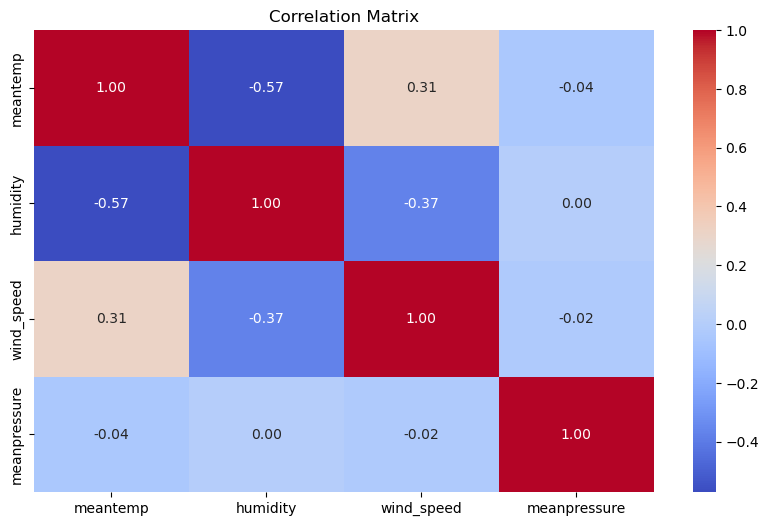

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(df_train.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

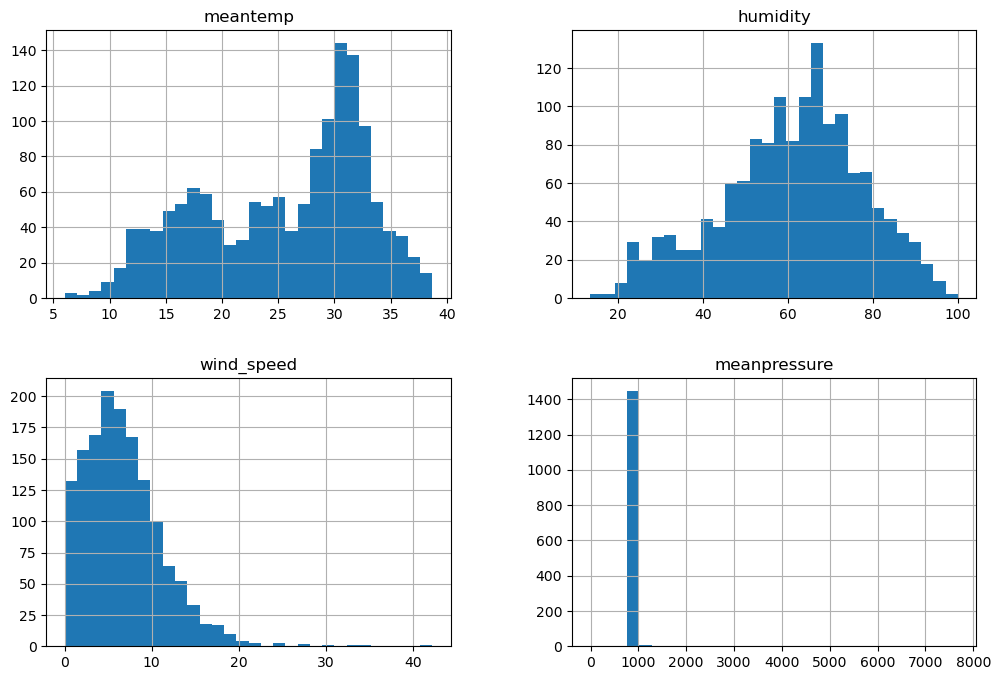

In [17]:
df_train.hist(figsize=(12, 8), bins=30)
plt.show()

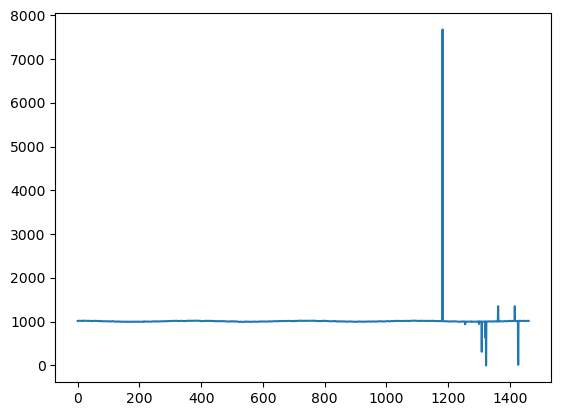

In [18]:
plt.plot(df_train["meanpressure"])

It look like that meanpressure doesnt have much information so we will remove this feature from the dataset

In [32]:
df_train.drop(columns="meanpressure", inplace=True)
df_test.drop(columns="meanpressure", inplace=True)
df_train.head()

,meantemp,humidity,wind_speed
0,10.000000,84.500000,0.000000
1,7.400000,92.000000,2.980000
2,7.166667,87.000000,4.633333
3,8.666667,71.333333,1.233333
4,6.000000,86.833333,3.700000


## 3. Data preproccessing

In [23]:
df_train.iloc[0:10, :]

,meantemp,humidity,wind_speed
0,10.000000,84.500000,0.000000
1,7.400000,92.000000,2.980000
2,7.166667,87.000000,4.633333
3,8.666667,71.333333,1.233333
4,6.000000,86.833333,3.700000
5,7.000000,82.800000,1.480000
6,7.000000,78.600000,6.300000
7,8.857143,63.714286,7.142857
8,14.000000,51.250000,12.500000
9,11.000000,62.000000,7.400000


In [33]:
# Define train set and test set
# In this model, we will predict the mean temperature of the next day using 10 previous days
import numpy as np
def create_sequences(data, seq_length=1):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length, :])  # Features
        y.append(data.iloc[i+seq_length, -1])     # Target (meantemp)
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(df_train, 10)
X_test, y_test = create_sequences(df_test, 10)

In [34]:
# Normalization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(df_train)
X_test = scaler.transform(df_test)

In [36]:
# Convert to dataframe
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [37]:
X_train.describe()

,0,1,2
count,1.462000e+03,1.462000e+03,1.462000e+03
mean,-1.458022e-17,1.968330e-16,-1.944029e-16
std,1.000342e+00,1.000342e+00,1.000342e+00
min,-2.654044e+00,-2.824109e+00,-1.491699e+00
25%,-9.037230e-01,-6.201833e-01,-7.296443e-01
50%,3.020541e-01,1.105528e-01,-1.273107e-01
75%,7.909894e-01,6.828386e-01,5.342114e-01
max,1.799551e+00,2.340044e+00,7.766988e+00
